In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]

In [3]:
#df = pd.read_csv('EURUSD.csv',sep='\t', index_col='Date')
#df.index = pd.to_datetime(df.index)
#df.sort_index(inplace=True)

In [4]:
df = pd.read_csv('МосБиржа_13years_1month_18072010_18072023.txt',sep=';')\
    .rename(columns={'<DATE>':'DATE','<OPEN>':'OPEN','<LOW>':'LOW','<CLOSE>':'CLOSE','<VOL>':'VOL','<HIGH>':'HIGH'})\
    .drop(['<PER>','<TIME>','<OPENINT>','<TICKER>'],1)
df.DATE = pd.to_datetime(df.DATE,format="%Y%m%d")
df.index = df.DATE

/tmp/ipykernel_21194/1159918590.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  .drop(['<PER>','<TIME>','<OPENINT>','<TICKER>'],1)


In [5]:
#df = df.resample('W').last()
series = df['CLOSE']

<Axes: xlabel='DATE'>

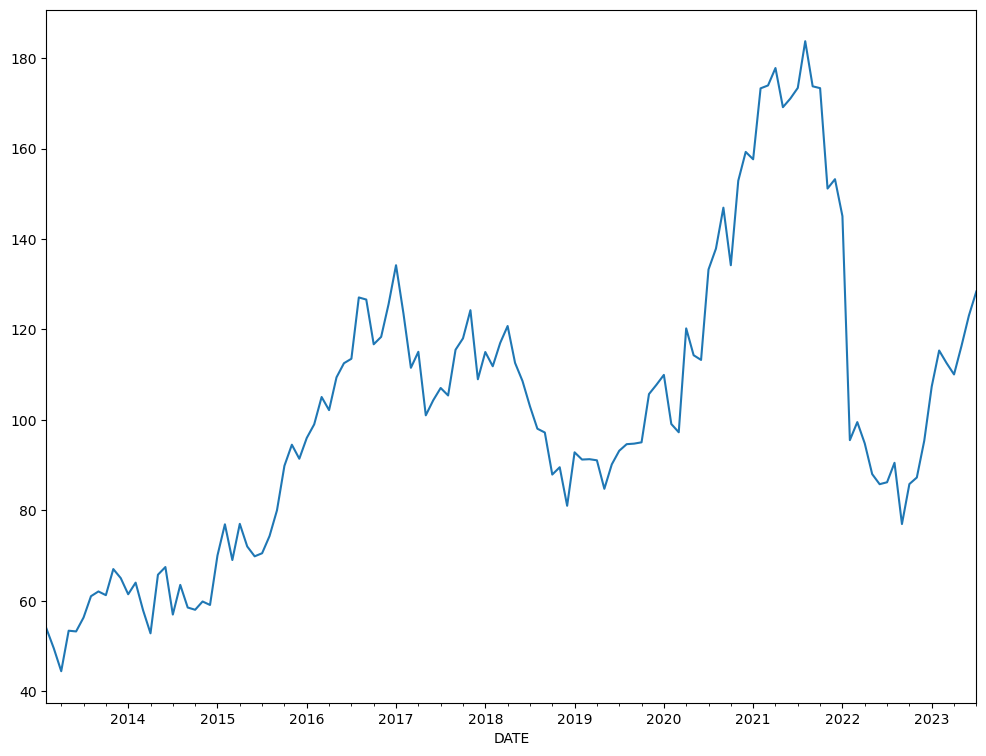

In [6]:
series.plot()

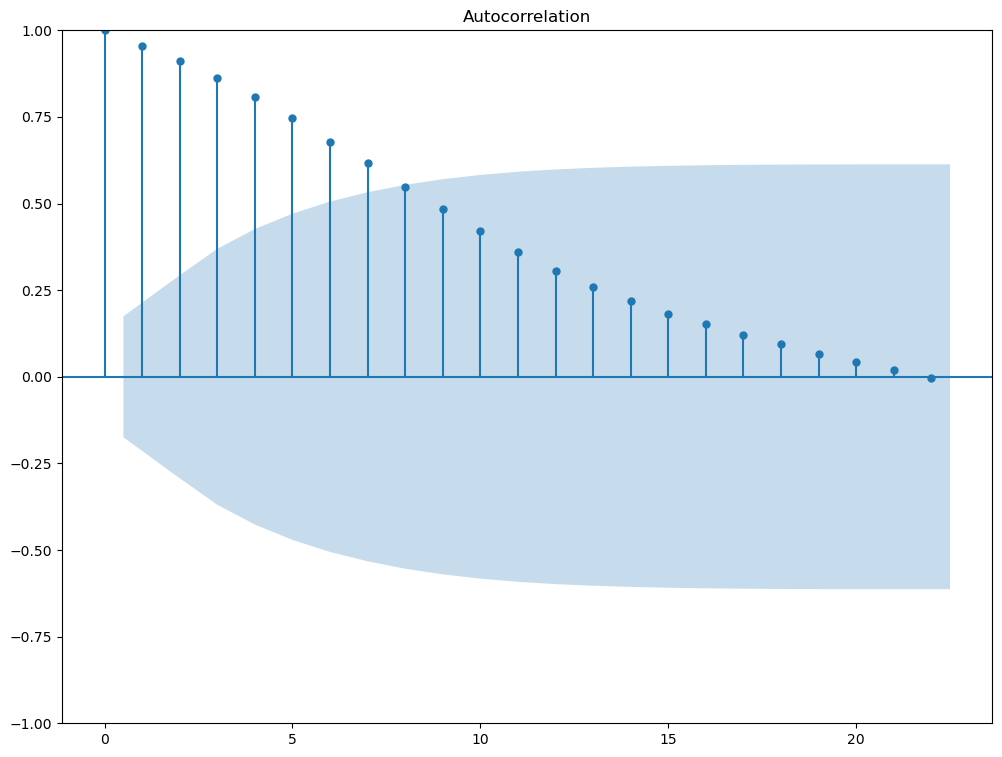

In [58]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series )
plt.show()

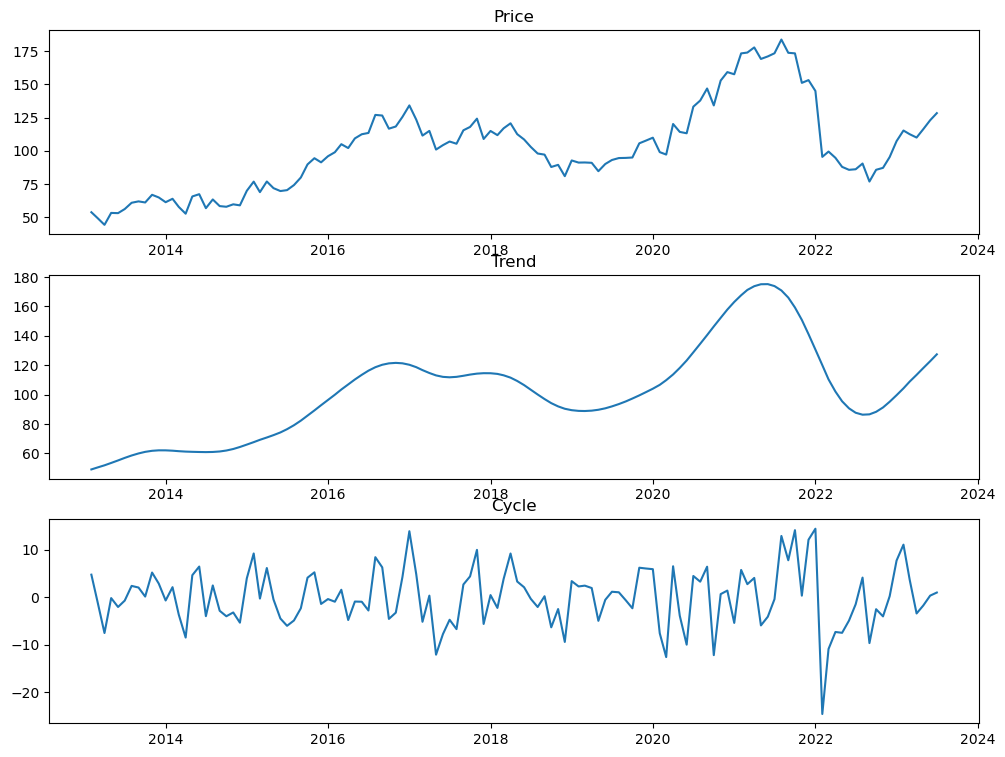

In [7]:
#HP - FILTER
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

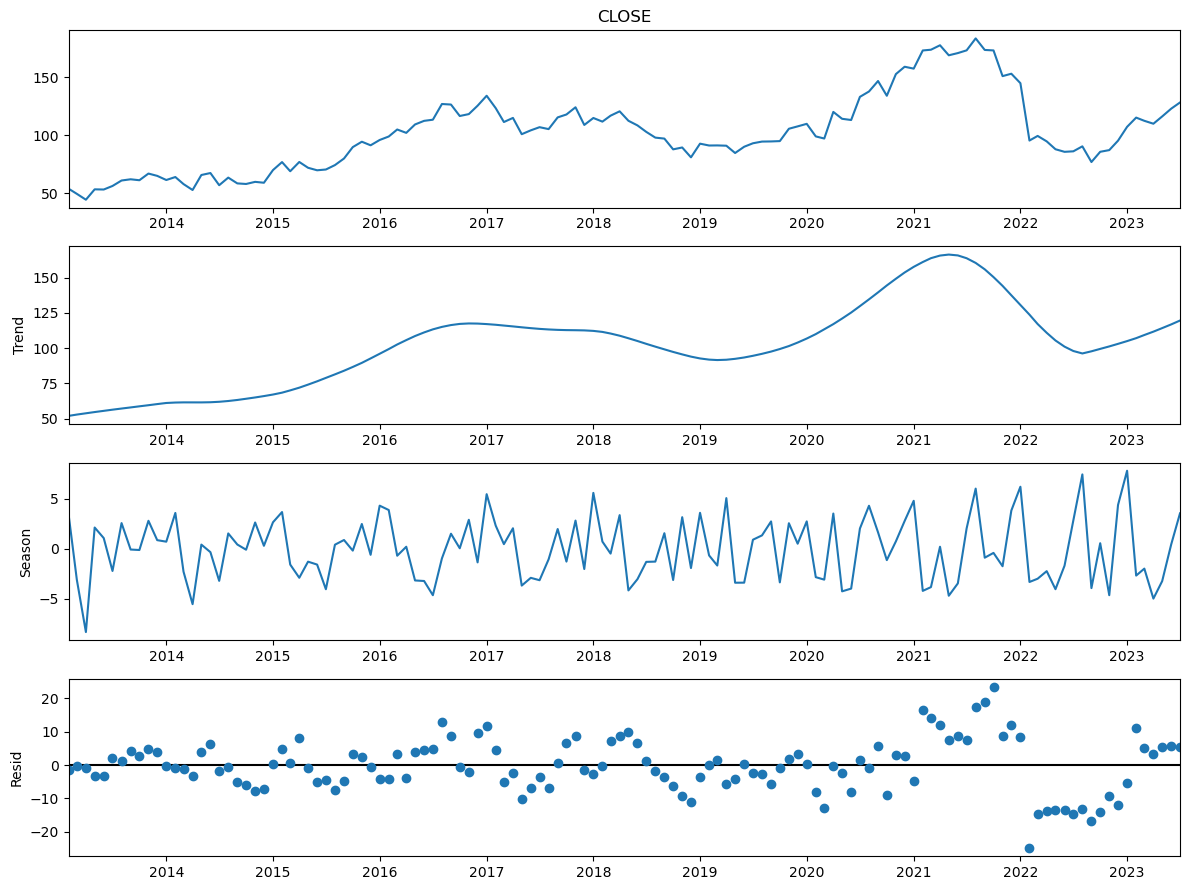

In [8]:
#STL -Decomposition
result = STL(series).fit()
chart = result.plot()
plt.show()

ПРОГНОЗИРУЕМ С НАИВНОЙ МОДЕЛЬЮ КОТОРАЯ ПРОСТО В КАЧЕСТВЕ СЛЕДУЮЩЕГО ПРОГНОЗИРУЕМНОГО ЗНАЧЕНИЯ СТАВИТ ПРЕДЫДУЩЕЕ

Test RMSE: 12.08000


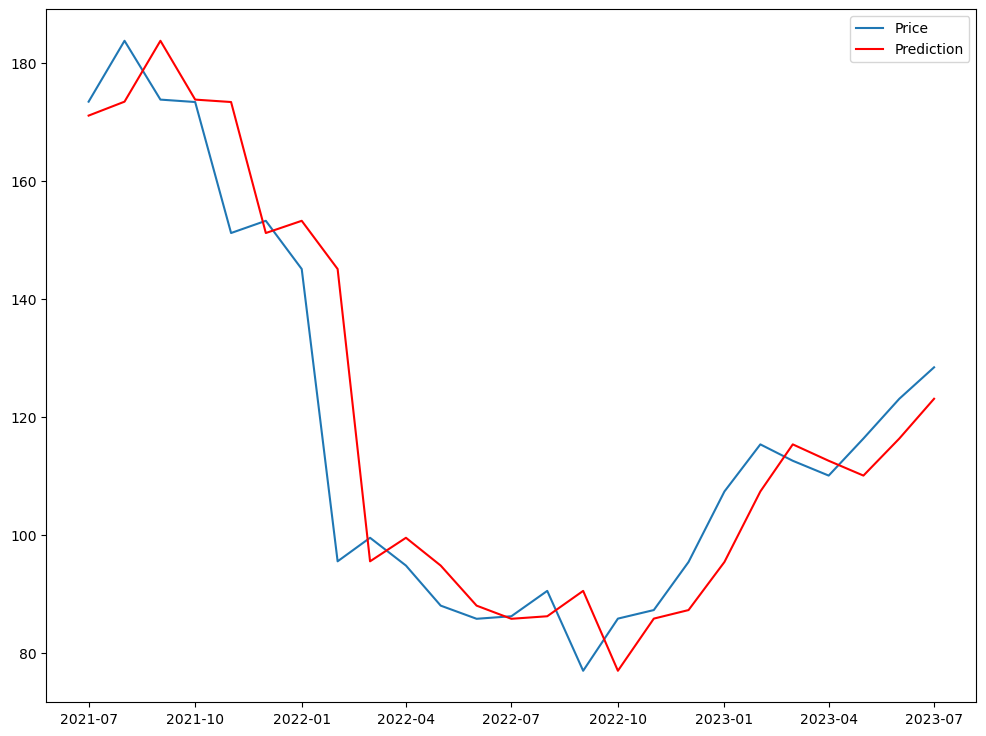

In [9]:
predictions = series.shift(1).dropna()
test_score = np.sqrt(mean_squared_error(series[int(len(series) * 0.7)+1:], predictions.iloc[int(len(series) * 0.7):]))
print('Test RMSE: %.5f' % test_score)
plt.plot(series.iloc[-25:], label='Price')
plt.plot(predictions[-25:], color='red', label='Prediction')
plt.legend()
plt.show()

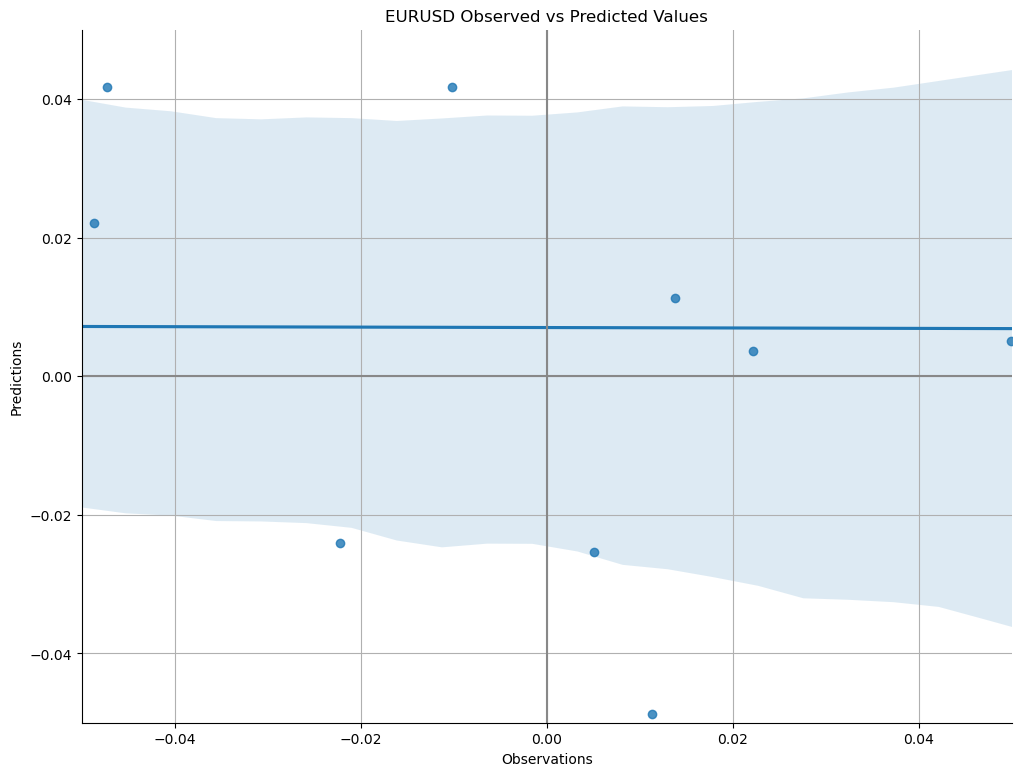

The MAE is 0.0952


In [10]:
fig, ax = plt.subplots()
ax = sns.regplot(x = series.iloc[-int(len(series) * 0.3):].pct_change()\
                 ,  y=predictions.iloc[-int(len(series) * 0.3):].pct_change(),)

plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - predictions.iloc[-int(len(series) * 0.3):].pct_change()).mean(),4)
print(f'The MAE is {mae}')

ВЫВОД - ПРОГНОЗ ПЛОХОЙ ТАК КАК НЕТ ВИДИМОЙ ВЗАИМОСВЯЗИ МЕЖДУ НАБЛЮДАЕМЫМИ ЗНАЧЕНИЯМИ И ПРОГНОЗАМИ

Посчитаем “частоту совпадений” того, как часто нам удается правильно предсказать направление движения пары EURUSD на следующей неделе

In [11]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), predictions.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 55.56%


ТЕПЕРЬ ПРОБУЕМ AR МОДЕЛЬ Приведенный ниже код берет наш временной ряд EURUSD и разбивает его на “обучающий” и “тестовый” наборы данных и создает пустой список, который мы собираемся использовать для хранения наших прогнозов. Это потому, что на этот раз мы собираемся делать наши еженедельные прогнозы один за другим, в режиме “пошагового продвижения”.

Мы собираемся выполнить итерацию по “циклу for” с количеством циклов, определяемым длиной наших тестовых данных - каждый раз в цикле мы собираемся создавать нашу AR–модель и передавать ей набор обучающих данных для обучения и подгонки к ней. После подгонки мы генерируем прогноз на 1 период вперед (который принимает форму единственного значения), мы добавляем это значение в наш список прогнозов, чтобы сохранить его. Важно отметить, что мы также извлекаем значение из тестовых данных, индекс которого соответствует текущему значению нашего итератора цикла for, и добавляем это значение в конец наших обучающих данных.


При следующем запуске наших циклов мы снова тренируем и подгоняем модель, но на этот раз в обучающих данных есть новое наблюдение, которое мы передаем ей, т.е. значение, которое мы только что добавили в последнем цикле for.


Это означает, что обучающие данные будут увеличиваться по мере того, как в каждом цикле к обучающим данным добавляется новое наблюдение. Это просто имитирует реальный ход времени, когда у нас есть доступ к данным за дополнительный день по сравнению с предыдущим днем.  Это просто гарантирует также, что мы не подвергаем нашу модель предвзятому взгляду в будущее и не обучаем ее, используя данные, которые были бы недоступны в то время.

In [12]:
from statsmodels.tsa.ar_model import AutoReg

Test MSE: 11.98939


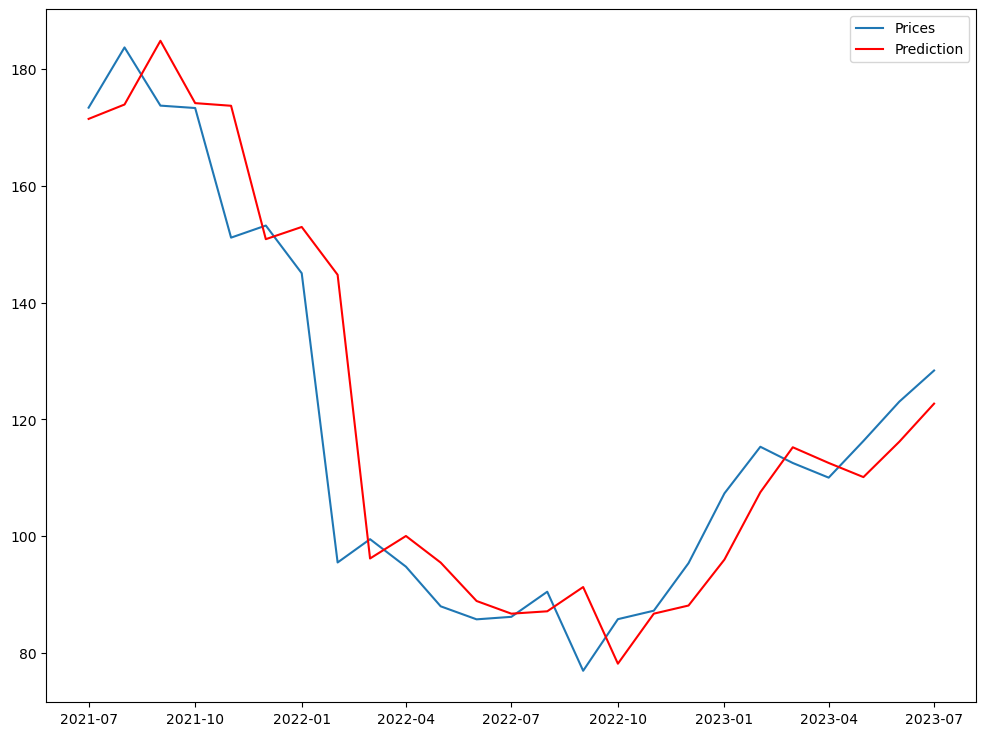

In [13]:
historic = series.iloc[:int(len(series) * 0.7)].to_list()
test = series.iloc[int(len(series) * 0.7):]
predictions = []
for i in range(len(test)):
    model = AutoReg(historic ,lags=1)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(test[i])
    
predictions = pd.Series(predictions, index=test.index)
    
test_score = np.sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.5f' % test_score)
# plot results
plt.plot(test.iloc[-25:], label='Prices')
plt.plot(predictions.iloc[-25:], color='red', label='Prediction')
plt.legend()
plt.show()


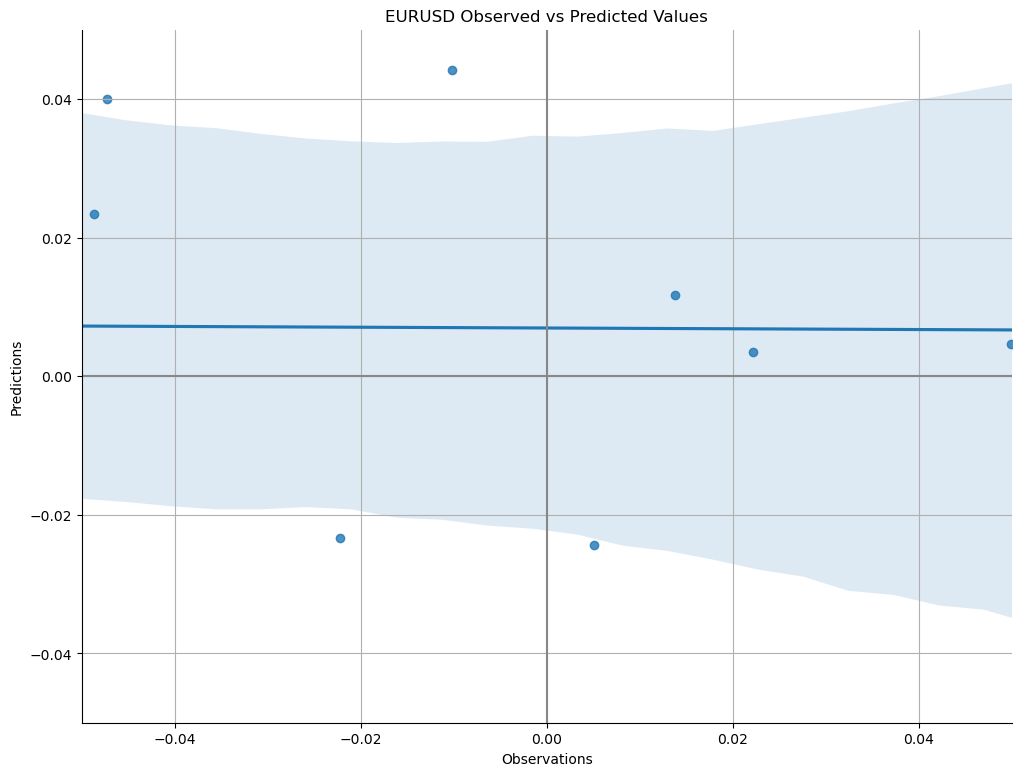

The MAE is 0.0976681409


In [14]:
fig, ax = plt.subplots()
ax = sns.regplot(x = series.iloc[-int(len(series) * 0.3):].pct_change(),
           y= predictions.iloc[-int(len(series) * 0.3):].pct_change(), )
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(test.pct_change() - predictions.pct_change()).mean(),10)
print(f'The MAE is {mae}')

ПОСЧИТАЕМ ЧАСТОТУ УГАДЫВАНИЯ НАПРАВЛЕНИЯ ДВИЖЕНИЯ АКТИВА

In [39]:
price_pred = pd.concat([test.pct_change(), predictions.pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 51.35%


ВЫВОД - МОДЕЛЬ ТАК ЖЕ ПЛОХО ПРЕДСКАЗЫВАЕТ КАК И НАИВНАЯ МОДЕЛЬ . 

Как упоминалось ранее, каждый компонент имеет различные характеристики, которые предполагают, что к ним следует подходить индивидуально более специализированным образом. Если мы сможем улучшить наши прогнозы, разбив временной ряд на составляющие, используя наши модели для прогнозирования компонентов по отдельности, то теоретически все, что нам нужно сделать, это рекомбинировать прогнозы обратно в полный временной ряд (т.е. просто сложить их все вместе), и в итоге мы получим более точный общий результат. предсказание.

Используем Hodrick-Prescott Filter для декомпозиции ряда 

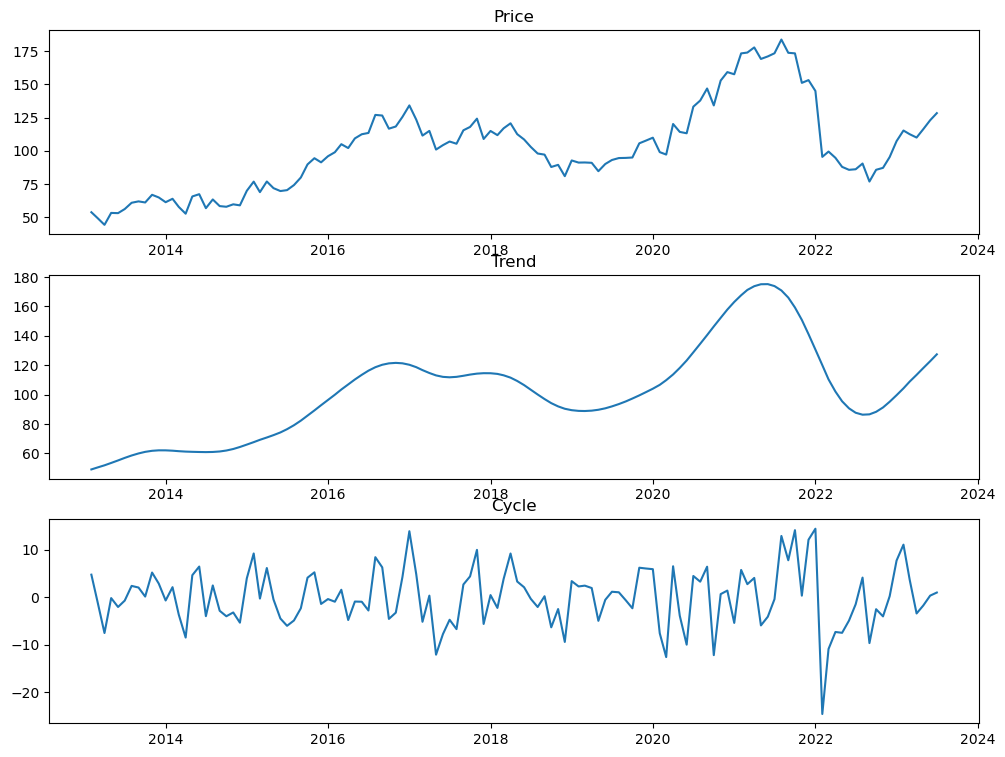

In [16]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()


Теперь нам нужно написать код для запуска нашей AR-модели таким же образом, как и раньше, но на этот раз с разложенными рядами в качестве входных данных.

Test for trend MSE: 0.1446165237286097


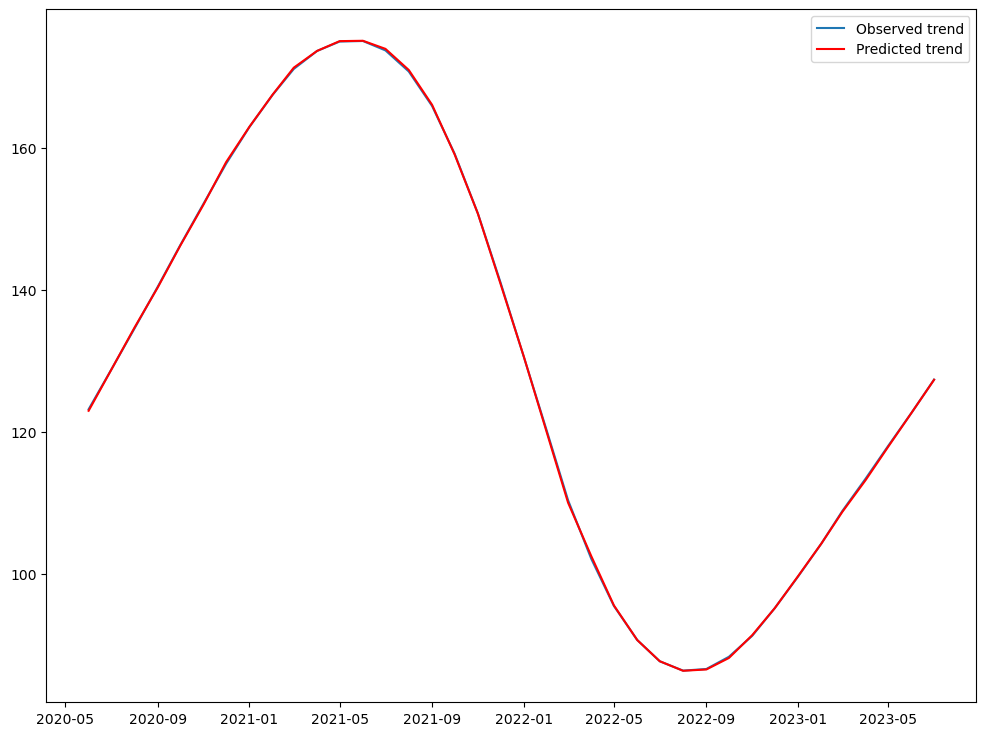

Test for cycle MSE: 8.402713954645776


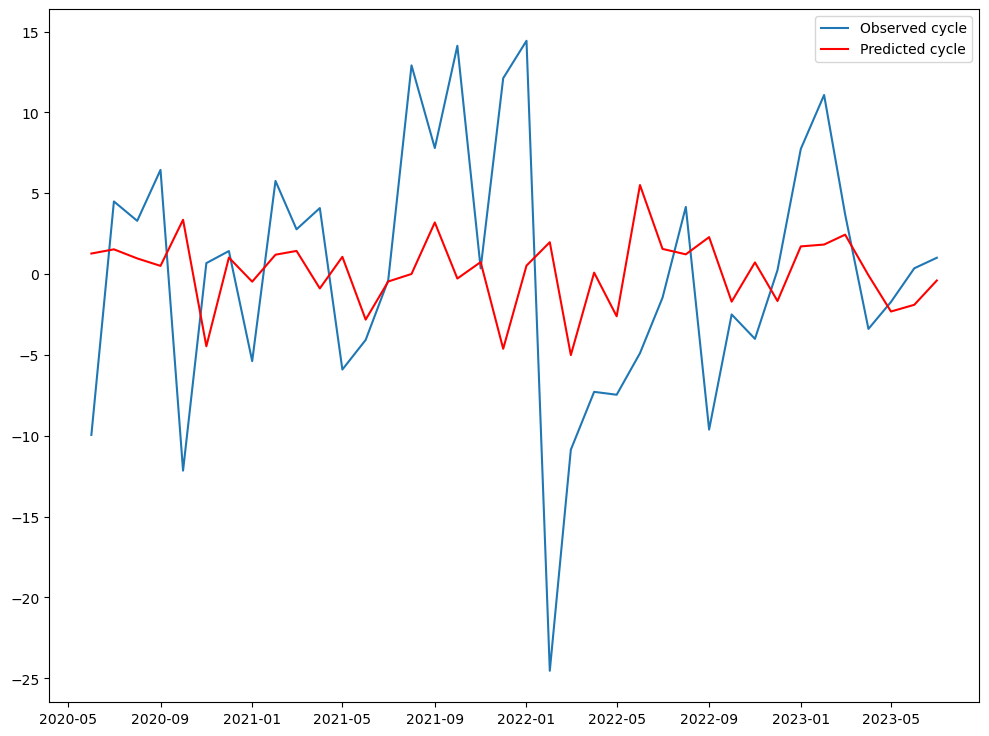

In [28]:
component_dict = {'cycle': cycle, 'trend': trend}
prediction_results = []
for component in ['trend', 'cycle']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]
    predictions = []
    for i in range(len(test)):
        model = AutoReg(historic,lags=4)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

Затем мы “перекомпоновываем” наши данные аддитивным образом и вычисляем RMSE при сравнении результирующей совокупной производительности прогнозирования с наблюдаемыми значениями.

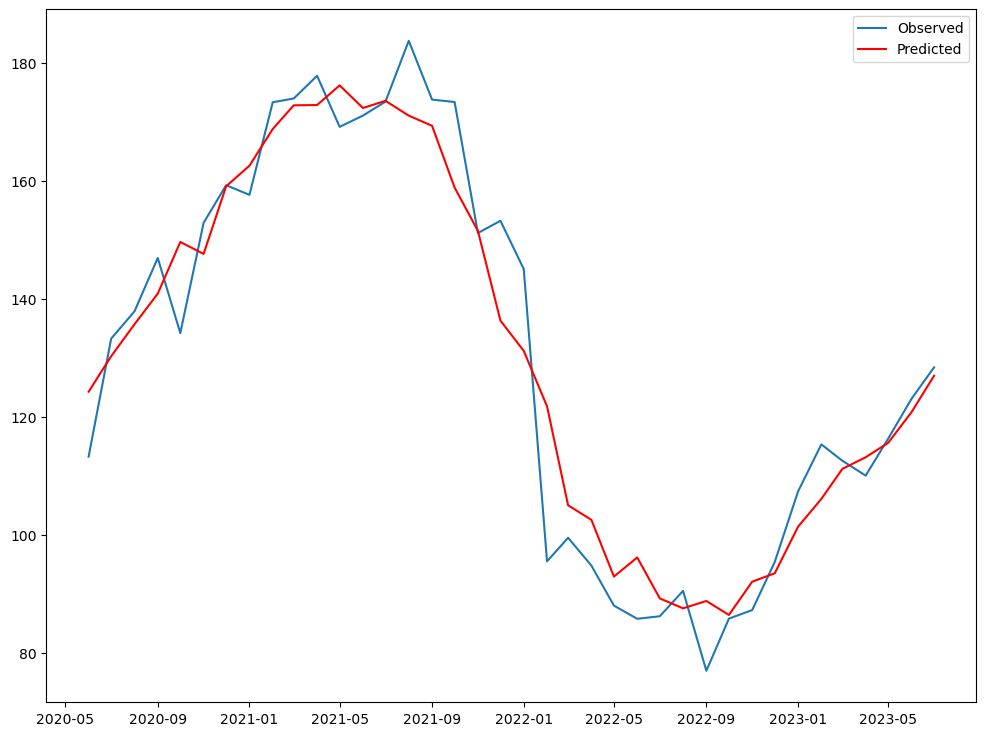

RMSE: 8.378372651029286


In [29]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
recomposed_preds.name = 'recomposed_preds'
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

Давайте построим нашу точечную диаграмму и рассчитаем новый MAE для этой модели.

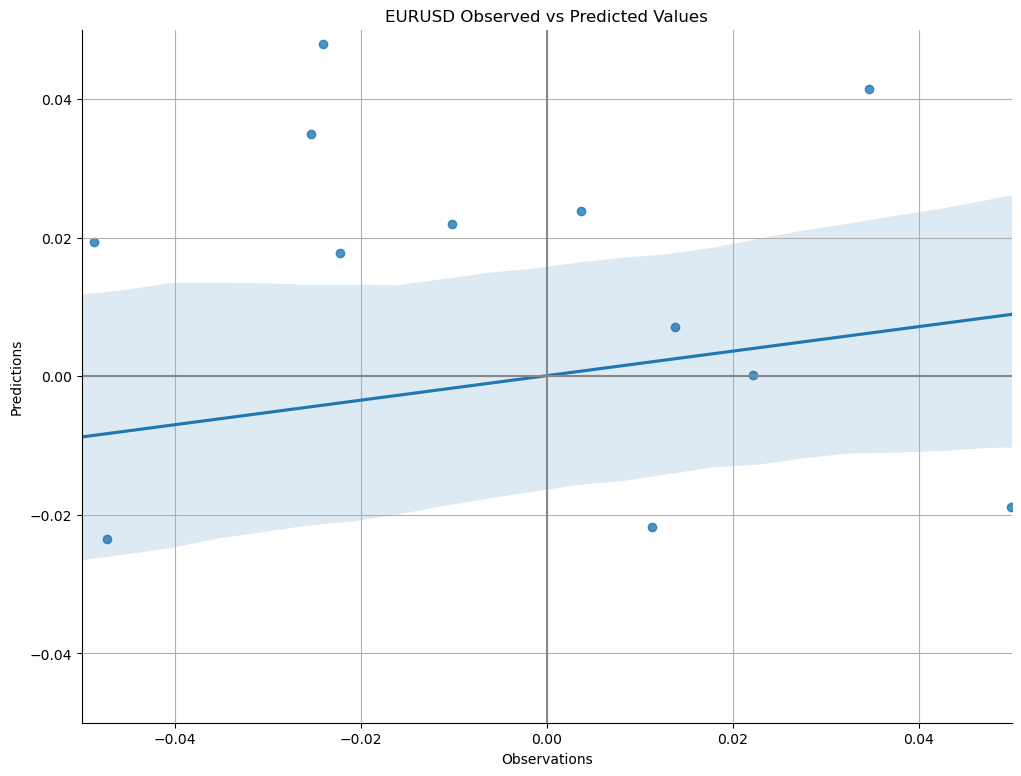

The MAE is 0.0659570733


In [30]:
fig, ax = plt.subplots()
ax = sns.regplot(x=series.iloc[-int(len(series) * 0.3):].pct_change(),
            y=recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change())
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

ПОСЧИТАЕМ ДОЛЮ УГАДАННЫХ НАПРАВЛЕНИЙ ДВИЖЕНИЯ АКТИВА

In [45]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(),recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 58.33%


НЕСМОТРЯ НА ТО ЧТО RMSE, MAE and Hit Rate ВЫРОСЛИ ПО СРАВНЕНИЮ С ПРЕДЫДУЩИМИ ДВУМЯ МОДЕЛЯМИ , МЫ НЕ ЗАНИМАЛИСЬ ОПТИМИЗАЦИЕЙ ПАРАМЕТРОВ .

Существует небольшая проблема с методом фильтрации HP. Алгоритм декомпозиции использует наблюдения, которые поступают как до, так и после текущей оценки. Это привносит в наш анализ элемент предвзятости “на перспективу”, которая является одним из наиболее распространенных предубеждений, влияющих на анализ людей и торговые/прогностические модели. В этом случае, когда вы точно знаете, как рассчитывается фильтр HP, это кажется совершенно очевидным, но если вы никогда не тратили время на ознакомление с методом расчета, это может легко остаться незамеченным.

Таким образом, в основном вышесказанное означает, что фильтр HP генерирует разложенные ряды, содержащие информацию из “будущего”, что делает наши прогнозы более точными в целом и приводит к тому, что наши перекомпонованные прогнозы также оказываются обманчиво точными.

ПОЭТОМУ ПОПРОБУЕМ ИСПОЛЬЗОВАТЬ STL ДЕКОМПОЗИЦИЮ КОТОРАЯ НЕ БЕРЕТ ДАННЫЕ ИЗ БУДУЩЕГО И ПОЭТОМУ МОЖЕТ ОКАЗАТЬСЯ БОЛЕЕ РЕАЛИСТИЧНОЙ В НАШЕЙ ЗАДАЧЕ . ПРОДЕЛЫВАЕМ ТУ ЖЕ РАБОТУ ЧТО И С HP ДЕКОМПОЗИЦИЕЙ 

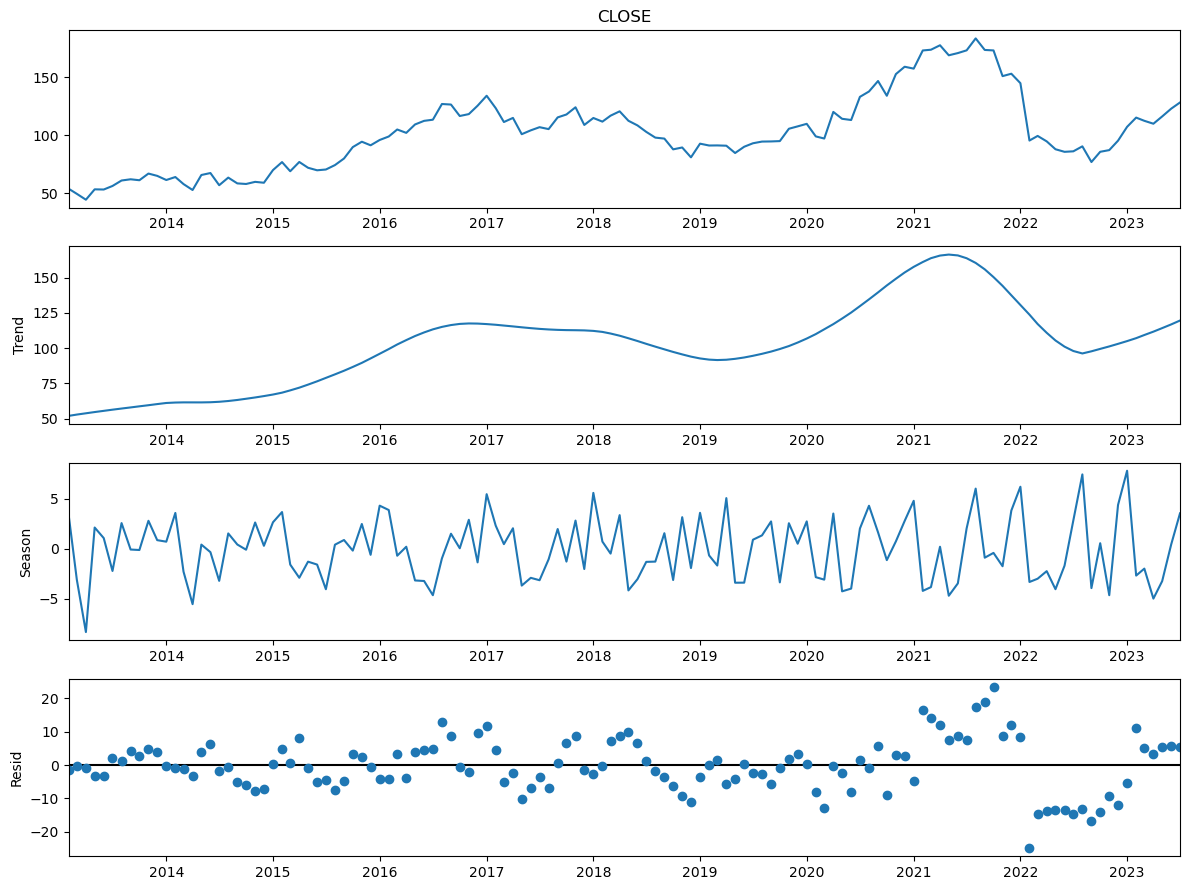

In [46]:
result = STL(series).fit()
result.plot()
plt.show()

Доступ к отдельным разложенным рядам можно получить из результирующего объекта следующим образом, используя либо “тренд”, либо “сезонный”, либо “resid”. В качестве примера мы распечатаем первые 5 строк сезонной серии ниже.

In [47]:
result.seasonal.head()

DATE
2013-02-01    3.407072
2013-03-01   -3.090309
2013-04-01   -8.328605
2013-05-01    2.139524
2013-06-01    1.081787
Name: season, dtype: float64

ДАЛЕЕ НАЧИНАЕМ ПРОГНОЗИРОВАТЬ AR МОДЕЛЬЮ КОМПОНЕНТЫ ПО ОТДЕЛЬНОТИ : ТЕПЕРЬ ЭТО БУДЕТ ТРЕНД СЕЗОННОСТЬ И ОСТАТКИ 

Test for seasonal MSE: 3.678608177169496


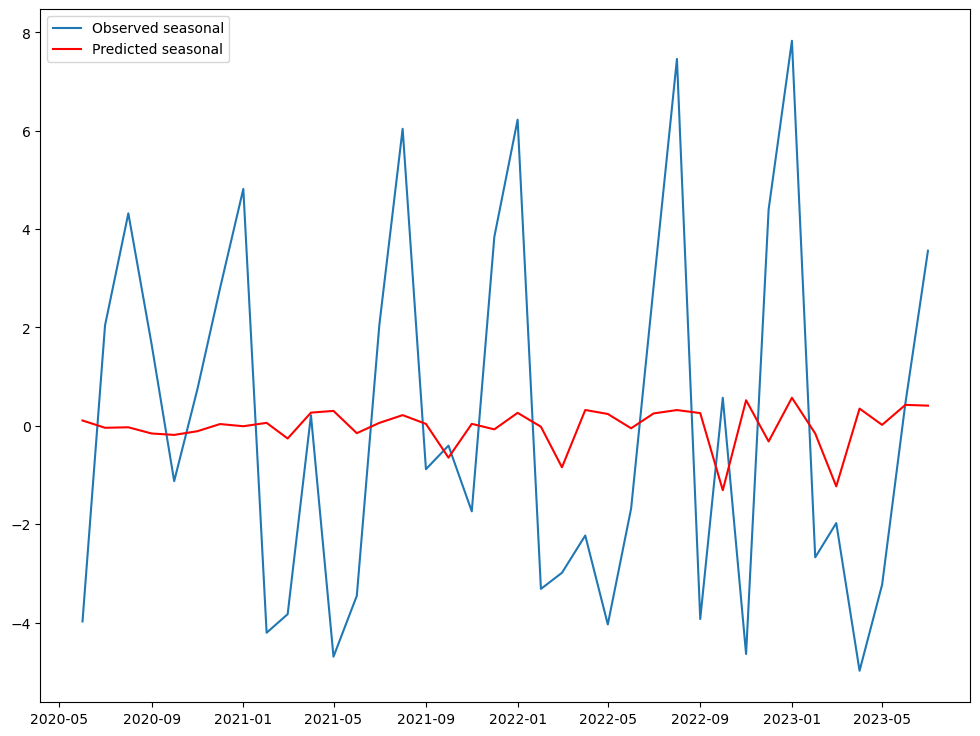

Test for trend MSE: 0.7790968676192658


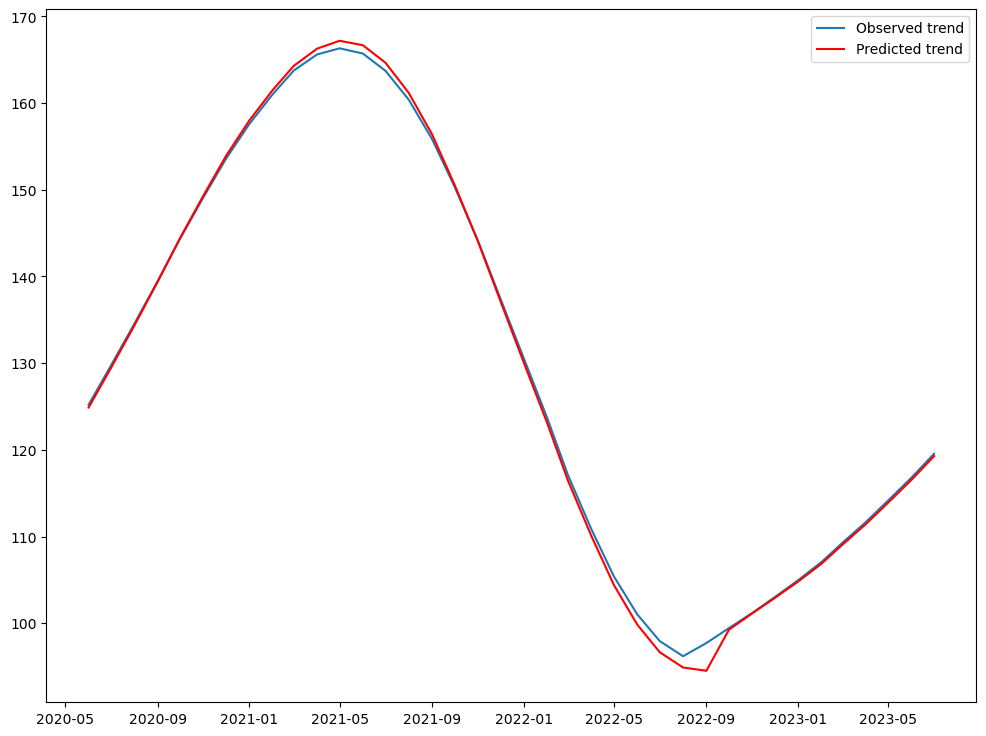

Test for residual MSE: 8.686265875094252


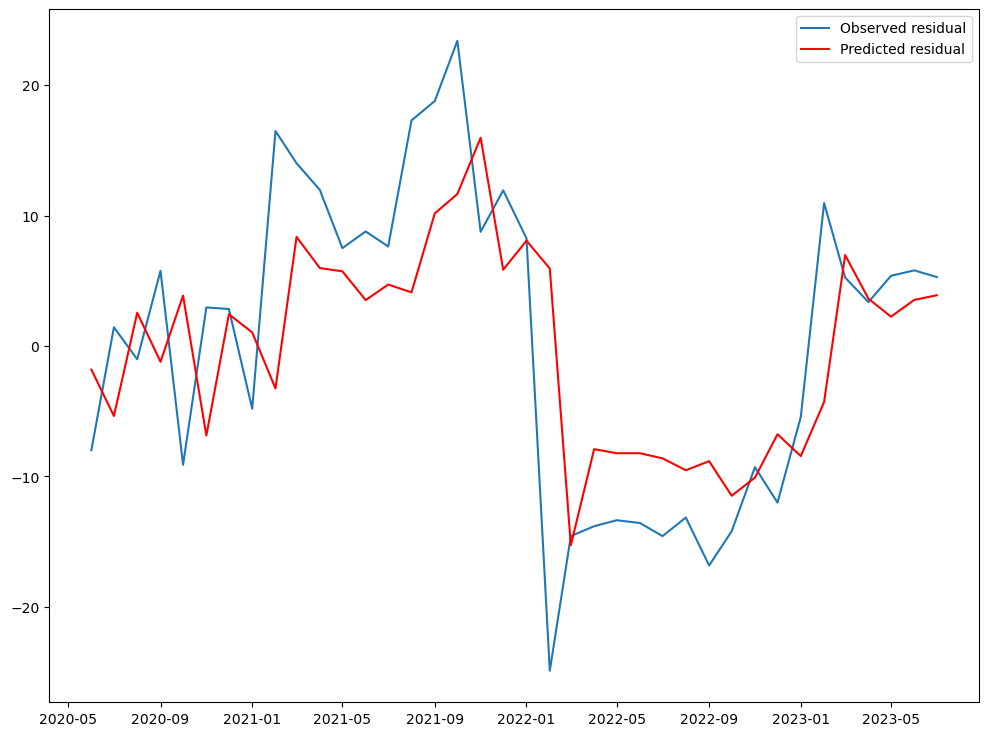

In [54]:
component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}
prediction_results = []
for component in ['seasonal', 'trend', 'residual']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]
    predictions = []
    for i in range(len(test)):
        model = AutoReg(historic , lags=2)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

ПРОВОДИМ РЕКОМПОЗИЦИЮ

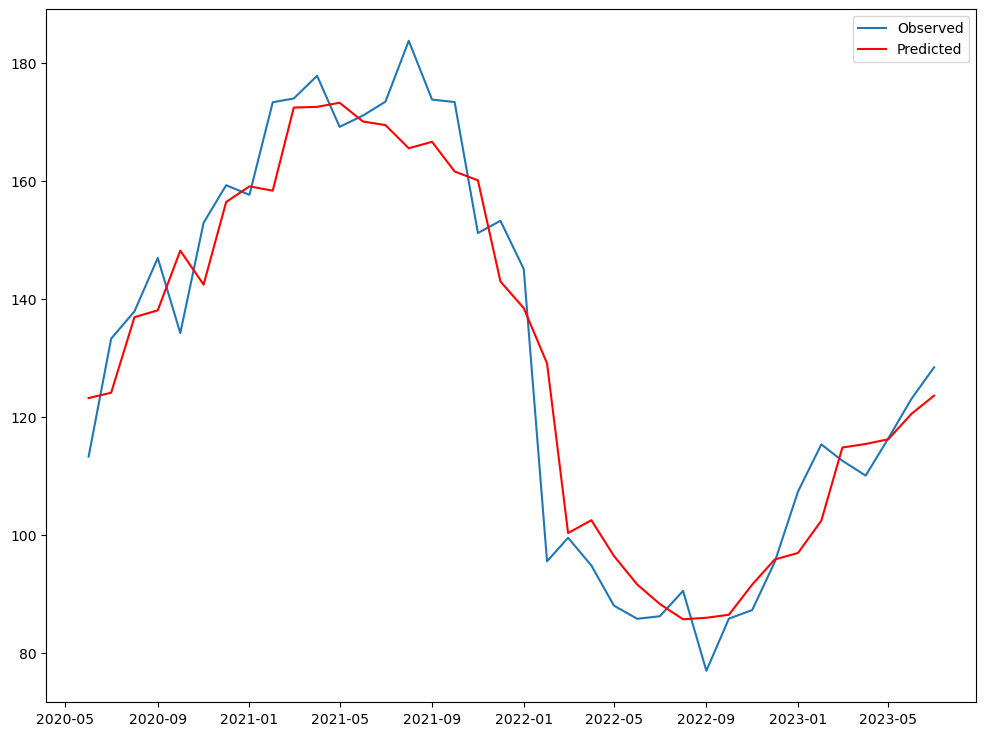

RMSE: 9.420967211542386


In [55]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

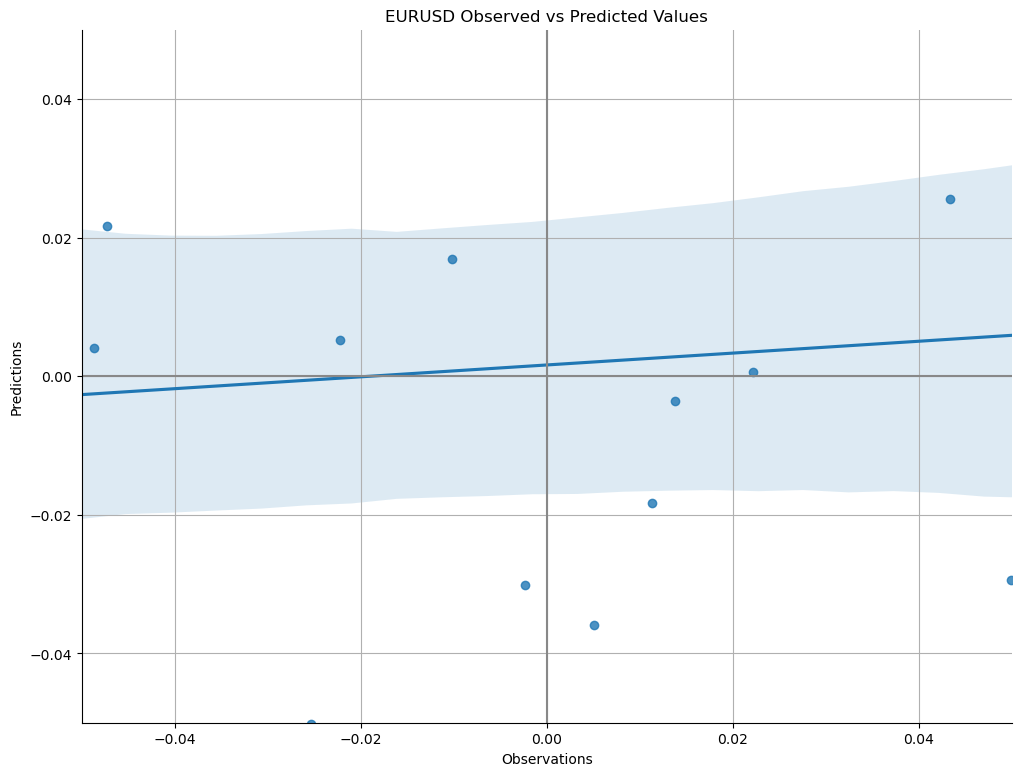

The MAE is 0.0777725429


In [56]:
fig, ax = plt.subplots()
ax = sns.regplot(x=series.iloc[-int(len(series) * 0.3):].pct_change(),
            y=recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change(), )
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

СЧИТАЕМ ЧАСТОТУ УГАДЫВАНИЙ НАПРАВЛЕНИЯ ДВИЖЕНИЯ АКТИВА

In [57]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 52.78%


ВЫВОД : С STL ДЕКОМПОЗИЦИЕЙ ПОКАЗАТЕЛИ RMSE MAE HIT RATE УПАЛИ ВНИЗ . 